M_s = 1.56
Eabt = 0.6219043176949249
Vp = 319649.4790275181
Wibt = 53077.30143869121
Qibt = 0.267
Wi100 = 210958.328339115
Qibt_star = 0.267
a1 = 2.269950759586476
Ei(a1) = 6.02516592908


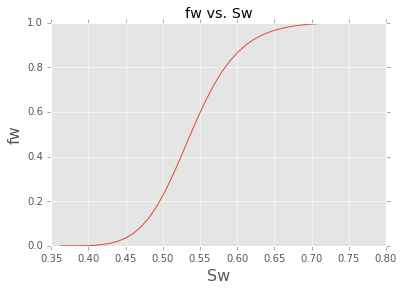

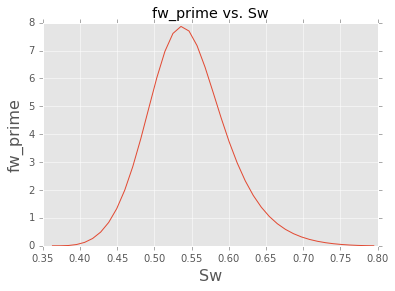

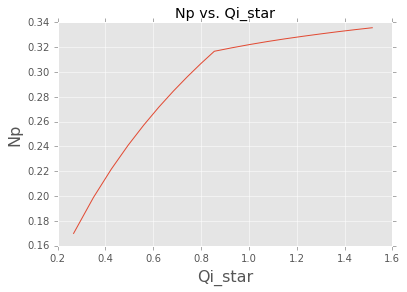

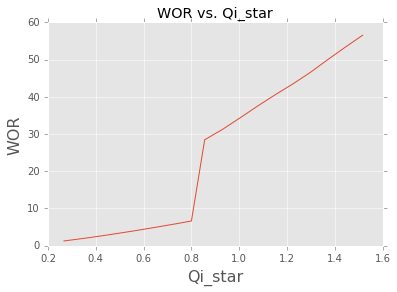

In [5]:
import numpy as np
import math
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
from scipy.special import expi as Ei

pd.options.display.max_rows = 999

%matplotlib inline
plt.style.use('ggplot')

def plotFunction(x, y):
    temp_figure = plt.figure()
    plt.plot(x, y)
    plt.title(y.name + " vs. " + x.name)
    plt.xlabel(x.name, fontsize=16)
    plt.ylabel(y.name, fontsize=16)
    plt.show()
    
    
    
# QUESTION 1
Sw_star = 1
phi = .206
k = 23 #md
Soi = .637 
Sor = .205
Swr = 1-Soi
Swi = Swr
mu_w = 1 #cp
mu_o  = 10 #cp 
h = 20 #ft
kro = (1-Sw_star)**2.56
krw = .78*Sw_star**3.72
Bo = 1
Bw = 1
A = 10 #acres

data = pd.DataFrame({"Sw": (np.linspace(Swi, 1, num=60))})
data['Sw_star'] = (data['Sw'] - Swr)/(1-Sor - Swr)
data['kro'] = (1-data.Sw_star)**2.56
data['krw'] = .78*data.Sw_star**3.72
data['fw'] = 1/(1 + (data.kro*mu_w)/(data.krw*mu_o))
data['fw_prime'] = (data.fw - data.fw.shift(+1).set_value(0, 0.00))/(data.Sw - data.Sw.shift(+1).set_value(0, 0.00))


Swf = .58
Swf_avg = .63
M_s = 1.56
Eabt = .54602036 + .03170817/M_s + .30222997/math.exp(M_s) - .00509693*M_s
Vp = (43560/5.6145)*A*h*phi
Wibt = Vp*Eabt*(Swf_avg - Swi)
Qibt = Wibt/(Eabt*Vp)
Wi100 = Wibt * math.exp((1-Eabt)/0.274)

print("M_s = " + str(M_s))
print("Eabt = " + str(Eabt))
print("Vp = " + str(Vp))
print("Wibt = " + str(Wibt))
print("Qibt = " + str(Qibt))
print("Wi100 = " + str(Wi100))


# Set up fw_prime vs Sw table in ascending order for fw_prime to get interpolate data later
temp_table = pd.concat([data['fw_prime'], data['Sw']], axis=1, keys=['fw_prime', 'Sw'])
temp_table = (temp_table.ix[18:40])
temp_table = temp_table.sort_values('fw_prime', ascending=True)


disp_table = pd.read_csv(r"C:\Users\jenng\OneDrive\School\Class of 2017 (UT)\Misc\PGE 323L -  Reservoir II\Homework\Homework 8\Question1Wi.csv", sep=',',header=0)


df1 = pd.DataFrame({"Wi": (np.linspace(Wibt, Wi100, num=10))})
df2 = pd.DataFrame({"Wi": (np.linspace(Wi100, Wi100*2, num=10))})
frames = [df1, df2]
disp_table = pd.concat(frames)
disp_table['Wi/Wibt'] = disp_table.Wi/Wibt


#Using Eq 4.6 to calculate Ea
disp_table['Ea'] = Eabt + .274*scipy.log(disp_table.Wi/Wibt)
disp_table['Ea'] = np.where(disp_table['Ea'] <= 1, disp_table['Ea'], 1)

# For Wi > Wi100, Qi_star = Qi100_star + (Wi-Wi100)/Vp
# For Wibt < Wi < Wi100, use Equation 4.20

Qibt_star = Wibt/Eabt/Vp

print("Qibt_star = " + str(Qibt_star))


a1 = 3.65*Eabt
print('a1 = ' + str(a1))
print('Ei(a1) = ' + str(Ei(a1)))
disp_table['a2'] = a1 + scipy.log(disp_table.Wi/Wibt)
disp_table['Ei(a2)'] = Ei(disp_table['a2'])
disp_table['4.20'] =  1 + (a1*math.exp(-1*a1)*(Ei(disp_table.a2) - Ei(a1)))

# From the 4.20 column for the first Ea value, Q = Qi100_star = .856
Qi100_star = 0.856  


disp_table['4.19'] = Qi100_star + ((disp_table.Wi - Wi100)/Vp)
disp_table['Qi_star'] = np.where(disp_table['Wi'] <= Wi100, disp_table['4.20']*Qibt_star, disp_table['4.19'])
disp_table['fw_prime'] = 1/disp_table['Qi_star']

# INTERPOLATE FW_PRIME FROM THE ORIGINAL FW_PRIME VS SW
disp_table['Sw2'] = np.interp(disp_table['fw_prime'], temp_table['fw_prime'], temp_table['Sw'])
disp_table['Sw_star2'] = (disp_table['Sw2'] - Swr)/(1-Sor- Swr)
disp_table['kro2'] = (1-disp_table.Sw_star2)**2.56
disp_table['krw2'] = .78*disp_table.Sw_star2**3.72
disp_table['fw2'] = 1/(1 + (disp_table.kro2*mu_w)/(disp_table.krw2*mu_o))
disp_table['fo2'] = 1 -disp_table.fw2

#USING EQ 4.12 in Willhite FOR Fw5
disp_table['Sw5'] = disp_table.Sw2 + disp_table.fo2*disp_table.Qi_star
disp_table['Np'] = disp_table.Ea*(disp_table.Sw5 - Swi)

# EA < 1  -> dNpy/Dwi -> WOR
# EA >= 1 -> WOR = Fw2/FO2
disp_table['dNdW'] = (.274*Wibt/disp_table.Wi)*(1/Eabt)*((Swf-Swi)/(Swf_avg-Swi))
disp_table['WOR-Ea<1'] = (1-disp_table.fo2)*(1-disp_table.dNdW)/(disp_table.fo2*(1-disp_table.dNdW) + disp_table.dNdW)
disp_table['WOR'] = np.where(disp_table['Ea'] < 1, disp_table['WOR-Ea<1'], (disp_table.fw2/disp_table.fo2))

plotFunction(data.Sw, data.fw)
plotFunction(data.Sw, data.fw_prime)

plotFunction(disp_table.Qi_star, disp_table.Np)
plotFunction(disp_table.Qi_star, disp_table.WOR)


writer = pd.ExcelWriter(r'C:\Users\jenng\OneDrive\School\Class of 2017 (UT)\Misc\PGE 323L -  Reservoir II\Homework\Homework 8\Question1.xlsx')
data.to_excel(writer, 'Fractional Flow Analysis')
disp_table.to_excel(writer, 'Displacement Table')
writer.save()




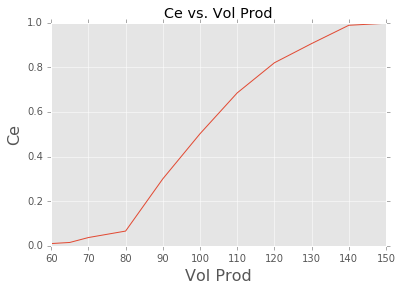

Finding the slope 2/sqrt(Npe)
Linear Regression: y = 0.253308062041x + 0.0222768799403
R value = 0.98877824266


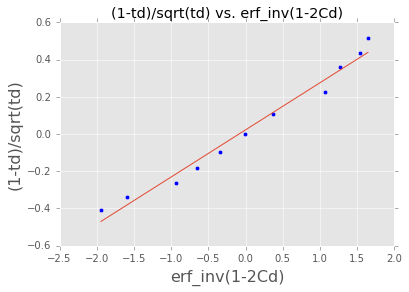

    Vol Prod     Ce    td      x      y   y_lr
0         60  0.010  0.60  1.645  0.516  0.439
1         65  0.015  0.65  1.534  0.434  0.411
2         70  0.037  0.70  1.263  0.359  0.342
3         80  0.066  0.80  1.065  0.224  0.292
4         90  0.300  0.90  0.371  0.105  0.116
5        100  0.502  1.00 -0.004  0.000  0.021
6        110  0.685  1.10 -0.341 -0.095 -0.064
7        120  0.820  1.20 -0.647 -0.183 -0.142
8        130  0.906  1.30 -0.931 -0.263 -0.214
9        140  0.988  1.40 -1.596 -0.338 -0.382
10       150  0.997  1.50 -1.943 -0.408 -0.470


In [6]:
# QUESTION 3

q3 = pd.read_csv(r"C:\Users\jenng\OneDrive\School\Class of 2017 (UT)\Misc\PGE 323L -  Reservoir II\Homework\Homework 8\Question3.csv", sep=',',header=0)
plotFunction(q3['Vol Prod'], q3['Ce'])

# td = 1
# xd = 1
# C from the solution will be = .5
# PV = 100 cm

q3['td'] = q3['Vol Prod']/100

q3['x'] = scipy.special.erfinv(1 - 2*q3.Ce)



q3['y'] = (1-q3['td'])/np.sqrt(q3['td'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(q3.x,q3.y)

print("Finding the slope 2/sqrt(Npe)")
print("Linear Regression: y = " + str(slope) + "x + " + str(intercept))
print("R value = " + str(r_value))

q3['y_lr'] = slope*q3.x + intercept


temp_figure = plt.figure()
plt.scatter(q3.x, q3.y)
plt.plot(q3.x, q3.y_lr )
plt.title("(1-td)/sqrt(td) vs. erf_inv(1-2Cd)")
plt.xlabel("erf_inv(1-2Cd)", fontsize=16)
plt.ylabel("(1-td)/sqrt(td)", fontsize=16)
plt.show()

print(q3.round(3))

